# Build a Word Embedding Engine and MVP Chatbot

In [1]:
!mkdir results

All results will be saved in: /content/results
Training aviation English embeddings...
Epoch 0, Loss: 17.6173
Epoch 20, Loss: 1.0148
Epoch 40, Loss: 0.2517
Epoch 60, Loss: 0.1360
Epoch 80, Loss: 0.0917
Saved model to: /content/results/embeddings.pt


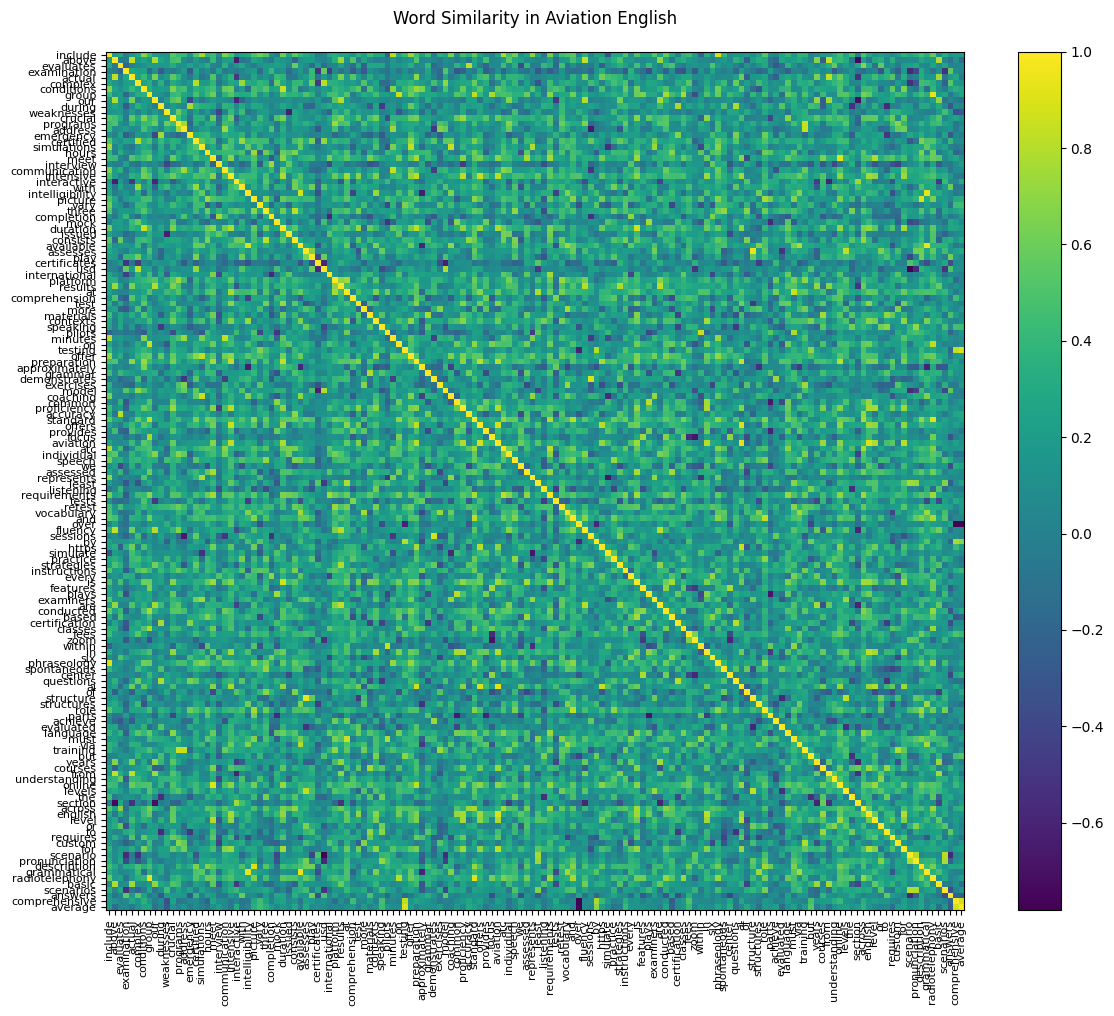

Saved similarity plot to: /content/results/similarity.png

Training complete! Proceed to the next cell for chatbot interaction.


In [1]:
# Cell 1: Model Training, Saving, and Visualization
import nltk
from nltk.tokenize import word_tokenize
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import os
import random
from datetime import datetime

# Create results directory
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)
print(f"All results will be saved in: {os.path.abspath(results_dir)}")

# Enhanced Aviation AI Corpus
corpus = [
    # Test information
    "The Aviation AI English Proficiency Test evaluates aviation English across six levels from 1 to 6.",
    "Pilots must achieve at least Aviation AI Level 4 to meet international language requirements.",
    "The test consists of three parts: interview, picture description, and role play scenarios.",
    "Aviation AI test duration is approximately 30-45 minutes conducted via Zoom or in-person.",
    "Test results and certificates are issued within 24 hours of completion.",

    # Preparation resources
    "https://sites.google.com/view/aviationai/home offers comprehensive Aviation AI test preparation materials.",
    "Our platform provides over 2,000 practice questions with model answers.",
    "wwe.aAviationAI.com features interactive exercises for phraseology training.",
    "Aviation English courses focus on radiotelephony and standard phraseology.",
    "Practice materials include ATC communication simulations and emergency scenarios.",

    # Test components
    "The speaking section assesses pronunciation, structure, vocabulary and fluency.",
    "Listening comprehension evaluates understanding of ATC instructions.",
    "Grammar accuracy is crucial for Aviation AI Level 4 and above.",
    "Pronunciation is assessed based on intelligibility in aviation contexts.",
    "Communication strategies are evaluated during emergency scenario role plays.",

    # Requirements
    "Aviation AI Level 4 requires basic grammatical structures and vocabulary.",
    "Level 5 demonstrates more complex structures and spontaneous speech.",
    "Level 6 represents native-like proficiency in aviation English.",
    "Pilots must retest every 3 years for Aviation AI English certification.",
    "Test fees vary by testing center but average $200-300 USD.",

    # Training options
    "We offer intensive 2-week Aviation AI preparation courses online.",
    "One-on-one coaching sessions with certified examiners available.",
    "Group classes focus on common aviation communication scenarios.",
    "Custom training programs address individual weaknesses.",
    "Mock tests simulate actual Aviation AI examination conditions."
]

class ICAOEmbeddingModel:
    def __init__(self, corpus, embedding_dim=16, window_size=3):
        nltk.download('punkt', quiet=True)
        nltk.download('punkt_tab', quiet=True)
        self.corpus = corpus
        self.embedding_dim = embedding_dim
        self.window_size = window_size
        self._build_vocabulary()
        self.embedding = nn.Embedding(len(self.vocab), embedding_dim)

    def _build_vocabulary(self):
        self.tokens = set(word for sentence in self.corpus
                        for word in word_tokenize(sentence.lower())
                        if word.isalpha())
        self.vocab = {word: i for i, word in enumerate(self.tokens)}
        self.idx2word = {i: word for word, i in self.vocab.items()}

    def build_co_occurrence_matrix(self):
        self.co_matrix = torch.zeros((len(self.vocab), len(self.vocab)))
        for sentence in self.corpus:
            words = [w for w in word_tokenize(sentence.lower()) if w in self.vocab]
            for i, center_word in enumerate(words):
                start = max(0, i - self.window_size)
                end = min(len(words), i + self.window_size + 1)
                for j in range(start, end):
                    if i != j:
                        self.co_matrix[self.vocab[center_word], self.vocab[words[j]]] += 1
        self.co_matrix += 0.1  # Smoothing

    def train(self, epochs=100, learning_rate=0.05):
        optimizer = optim.Adam(self.embedding.parameters(), lr=learning_rate)
        loss_fn = nn.MSELoss()
        word_indices = torch.arange(len(self.vocab))

        for epoch in range(epochs):
            optimizer.zero_grad()
            embeddings = self.embedding(word_indices)
            sim_scores = torch.mm(embeddings, embeddings.t())
            loss = loss_fn(sim_scores, self.co_matrix)
            loss.backward()
            optimizer.step()
            if epoch % 20 == 0:
                print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

    def save_embeddings(self, filepath='model_results/embeddings.pt'):
        os.makedirs(os.path.dirname(filepath), exist_ok=True)
        torch.save({
            'model_state': self.embedding.state_dict(),
            'vocab': self.vocab,
            'idx2word': self.idx2word,
            'config': {
                'embedding_dim': self.embedding_dim,
                'window_size': self.window_size
            }
        }, filepath)
        print(f"Saved model to: {os.path.abspath(filepath)}")

    def save_similarity_plot(self, filepath='model_results/similarity.png'):
        os.makedirs(os.path.dirname(filepath), exist_ok=True)
        with torch.no_grad():
            embeddings = self.embedding(torch.arange(len(self.vocab)))
            similarities = cosine_similarity(embeddings.numpy())

            plt.figure(figsize=(12, 10))
            plt.imshow(similarities, cmap='viridis')
            plt.xticks(range(len(self.vocab)), [self.idx2word[i] for i in range(len(self.vocab))],
                      rotation=90, fontsize=8)
            plt.yticks(range(len(self.vocab)), [self.idx2word[i] for i in range(len(self.vocab))],
                      fontsize=8)
            plt.title("Word Similarity in Aviation English", pad=20)
            plt.colorbar()
            plt.tight_layout()
            plt.savefig(filepath, dpi=300, bbox_inches='tight')
            plt.show()
            plt.close()
            print(f"Saved similarity plot to: {os.path.abspath(filepath)}")

    def get_sentence_embedding(self, sentence):
        tokens = [word for word in word_tokenize(sentence.lower())
                 if word in self.vocab and word.isalpha()]
        if not tokens:
            return None
        indices = torch.tensor([self.vocab[word] for word in tokens])
        with torch.no_grad():
            return self.embedding(indices).mean(dim=0).numpy()

# Initialize and train model
print("Training aviation English embeddings...")
model = ICAOEmbeddingModel(corpus)
model.build_co_occurrence_matrix()
model.train(epochs=100)

# Save results
model.save_embeddings(os.path.join(results_dir, "embeddings.pt"))
model.save_similarity_plot(os.path.join(results_dir, "similarity.png"))

print("\nTraining complete! Proceed to the next cell for chatbot interaction.")

In [2]:
# Cell 2: Chatbot Interface
intent_bank = {
    "test_format": [
        "What does the ICAO test consist of?", "How is the ICAO exam structured?",
        "What are the components of the aviation English test?", "Tell me about the test format",
        "Breakdown of ICAO English test sections", "What can I expect during the ICAO assessment?",
        "Describe the structure of the ICAO language proficiency test", "What are the different parts of the ICAO exam?",
        "How is the aviation English test organized?", "Test format for ICAO language proficiency"
    ],
    "preparation": [
        "How can I prepare for the ICAO test?", "What resources are available for study?",
        "Where can I find practice materials?", "Recommend preparation methods",
        "Best way to study for ICAO English", "Preparation tips for aviation English test",
        "How should I practice for the ICAO exam?", "What study materials are recommended?",
        "Effective preparation strategies for ICAO", "Where to find ICAO test practice questions"
    ],
    "requirements": [
        "What level do I need to pass?", "What are the ICAO language requirements?",
        "How good does my English need to be?", "What's the minimum passing grade?",
        "Required proficiency level for pilots", "ICAO language proficiency standards",
        "Minimum English level for aviation", "What ICAO level is mandatory?",
        "Language requirements for airline pilots", "Is Level 4 sufficient for all airlines?"
    ],
    "retesting": [
        "How often do I need to retest?", "Is the certification permanent?",
        "When does my certificate expire?", "Retesting frequency",
        "Validity period of ICAO English certificate", "How long is my test result valid?",
        "When should I renew my ICAO certification?", "Do I need to retake the test periodically?",
        "Expiration of aviation English results", "How frequently must pilots retest?"
    ],
    "scoring": [
        "How is the test scored?", "What criteria are used for evaluation?",
        "How do they assess pronunciation?", "What makes a Level 6 candidate?",
        "ICAO rating scale explanation", "How are the six levels determined?",
        "What distinguishes Level 4 from Level 5?", "Scoring methodology for aviation English",
        "Evaluation criteria for ICAO test", "What examiners look for during assessment"
    ],
    "training": [
        "Do you offer preparation courses?", "Where can I get training?",
        "Recommend good aviation English schools", "Looking for ICAO test coaching",
        "Best courses for ICAO preparation", "Aviation English training programs",
        "Where to take ICAO test preparation", "Recommendations for language schools",
        "Online courses for ICAO English", "In-person training options for pilots"
    ],
    "pronunciation": [
        "How important is pronunciation in the test?", "What pronunciation features are evaluated?",
        "How to improve aviation English pronunciation", "Common pronunciation mistakes in ICAO test",
        "Does accent affect my ICAO score?", "Pronunciation requirements for Level 4",
        "Tips for clear aviation communication", "How to practice ATC pronunciation",
        "What makes pronunciation 'intelligible'?", "Phonetic challenges in aviation English"
    ],
    "grammar": [
        "What grammar level is needed for ICAO?", "Common grammar mistakes in the test",
        "How to improve aviation English grammar", "Grammar requirements for Level 4",
        "Most important grammar for pilots", "Does grammar affect my test score?",
        "Essential verb tenses for ICAO", "Grammar practice for aviation English",
        "Complex grammar needed for Level 6", "How examiners evaluate grammar"
    ],
    "vocabulary": [
        "What vocabulary is tested in ICAO?", "Essential aviation English terms",
        "How to expand my aviation vocabulary", "Standard phraseology practice",
        "Vocabulary requirements by level", "Technical terms for ICAO test",
        "Where to learn ATC vocabulary", "Most important words for pilots",
        "Vocabulary for emergency situations", "Radio communication phrases to know"
    ],
    "fluency": [
        "What is expected for fluency at Level 4?", "How to improve speaking fluency",
        "Does hesitation affect my score?", "Fluency requirements in ICAO test",
        "Tips for smooth communication", "How to reduce pauses in speech",
        "Speaking rate expectations", "Fluency differences between levels",
        "Practicing spontaneous responses", "Balancing speed and clarity"
    ],
    "comprehension": [
        "How is listening comprehension tested?", "Tips for understanding ATC instructions",
        "Comprehension requirements by level", "How to practice aviation listening",
        "What accents might I hear in the test?", "Improving quick understanding",
        "Common comprehension challenges", "Resources for ATC communication practice",
        "How examiners test comprehension", "Strategies for better understanding"
    ],
    "interaction": [
        "How is interactive communication assessed?", "Tips for role-play scenarios",
        "Handling unexpected questions", "Interaction skills for Level 6",
        "How to practice communication strategies", "What makes good pilot-controller interaction",
        "Clarification techniques in aviation", "Asking and answering questions effectively",
        "Managing miscommunication scenarios", "Interactive requirements by level"
    ],
    "test_day": [
        "What to expect on test day?", "How to prepare the night before",
        "Test day tips for success", "What to bring to the exam",
        "How long does the test take?", "Dress code for ICAO assessment",
        "Can I take notes during the test?", "How to manage test anxiety",
        "What happens if I'm late?", "Breaks during the examination"
    ],
    "resources": [
        "Recommended books for ICAO preparation", "Best apps for aviation English",
        "Free resources for practice", "Online practice tests available",
        "YouTube channels for pilots", "Podcasts for aviation English",
        "Mobile apps for phraseology", "Where to find ATC recordings",
        "Simulators for communication practice", "Official ICAO documentation"
    ],
    "special_cases": [
        "What if I fail the test?", "Retake policies and procedures",
        "Accommodations for disabilities", "Testing with hearing difficulties",
        "Non-native speaker challenges", "Age considerations for testing",
        "Testing during COVID restrictions", "Emergency rescheduling",
        "Special circumstances appeals", "Testing for non-pilots"
    ]
}

responses = {
    "test_format": (
        "📝 ICAO Test Structure (30-45 minutes):\n\n"
        "1. INTERVIEW (5-10 mins):\n"
        "   - Personal aviation experience\n"
        "   - Routine operations discussion\n\n"
        "2. PICTURE DESCRIPTION (5-10 mins):\n"
        "   - Describe aviation scenarios\n"
        "   - Explain procedures shown\n\n"
        "3. ROLE-PLAY (10-15 mins):\n"
        "   - ATC communication scenarios\n"
        "   - Emergency situation handling\n\n"
        "💡 Available formats: In-person or via Zoom\n"
        "⚖️ All sections equally weighted in scoring"
    ),

    "preparation": (
        "📚 Recommended ICAO Preparation:\n\n"
        "OFFICIAL RESOURCES:\n"
        "• ICAO Doc 9835 Manual\n"
        "• Level6Aviation's question bank (2,000+ items)\n\n"
        "PRACTICE METHODS:\n"
        "1. Daily ATC communication listening (LiveATC.net)\n"
        "2. Standard phraseology drills\n"
        "3. Mock tests with certified examiners\n"
        "4. Aviation scenario role-plays\n\n"
        "⏳ Minimum recommended preparation: 3 months"
    ),

    "requirements": (
        "📊 ICAO Proficiency Levels:\n\n"
        "LEVEL 4 (Operational - Minimum Standard):\n"
        "• Pronunciation: Mostly intelligible\n"
        "• Grammar: Basic structures, some errors\n"
        "• Vocabulary: Routine operations\n"
        "• Fluency: Some hesitation\n\n"
        "LEVEL 6 (Expert):\n"
        "• Pronunciation: Native-like clarity\n"
        "• Grammar: Complex structures accurately\n"
        "• Vocabulary: Precise technical terms\n"
        "• Fluency: Spontaneous, natural pace\n\n"
        "✈️ Most airlines require Level 4 minimum"
    ),

    "retesting": (
        "🔄 ICAO Certification Validity:\n\n"
        "TEST VALIDITY PERIODS:\n"
        "• Level 4: 3 years\n"
        "• Level 5: 6 years\n"
        "• Level 6: Lifetime validity\n\n"
        "AIRLINE POLICIES:\n"
        "• Most require renewal every 3 years\n"
        "• Some accept previous test reports\n"
        "• Recurrent training may substitute\n\n"
        "⚠️ Check with your aviation authority"
    ),

    "scoring": (
        "📈 ICAO Assessment Criteria (1-6 scale):\n\n"
        "1. PRONUNCIATION:\n"
        "   - Stress, rhythm, intonation\n"
        "   - Sound production\n\n"
        "2. STRUCTURE:\n"
        "   - Grammar accuracy\n"
        "   - Sentence construction\n\n"
        "3. VOCABULARY:\n"
        "   - Range and precision\n"
        "   - Technical terms\n\n"
        "4. FLUENCY:\n"
        "   - Speech rate\n"
        "   - Hesitation patterns\n\n"
        "5. COMPREHENSION:\n"
        "   - ATC instruction understanding\n"
        "   - Contextual awareness\n\n"
        "6. INTERACTIONS:\n"
        "   - Turn-taking\n"
        "   - Clarification strategies\n\n"
        "🔍 Final level determined by lowest sub-score"
    ),

    "training": (
        "🎓 ICAO Training Options:\n\n"
        "ONLINE COURSES:\n"
        "• Level6Aviation (4-week intensive)\n"
        "• ICAO Training Institute (self-paced)\n\n"
        "IN-PERSON OPTIONS:\n"
        "1. Aviation English Schools:\n"
        "   - Oxford Aviation Academy\n"
        "   - Jeppesen Training Centers\n\n"
        "2. University Programs:\n"
        "   - Embry-Riddle Aeronautical University\n"
        "   - University of North Dakota\n\n"
        "💰 Cost range: $200-$800 depending on format"
    ),

    "pronunciation": (
        "🗣 ICAO Pronunciation Standards:\n\n"
        "KEY ELEMENTS:\n"
        "• Intelligibility in aviation context\n"
        "• Word stress patterns\n"
        "• Sentence rhythm\n"
        "• Critical sound contrasts\n\n"
        "COMMON CHALLENGES:\n"
        "1. Vowel length distinctions\n"
        "2. Consonant clusters\n"
        "3. Stress-timing\n\n"
        "PRACTICE TECHNIQUES:\n"
        "• Shadowing ATC recordings\n"
        "• Minimal pair drills\n"
        "• Speech visualization software"
    ),

    "grammar": (
        "📝 ICAO Grammar Requirements:\n\n"
        "ESSENTIAL STRUCTURES:\n"
        "1. Verb Tenses:\n"
        "   - Present continuous (We're climbing to FL350)\n"
        "   - Future simple (We will divert)\n\n"
        "2. Modals:\n"
        "   - Should/Shouldn't (advice)\n"
        "   - May/Might (possibility)\n\n"
        "3. Conditionals:\n"
        "   - Type 1 (If we don't get clearance...)\n\n"
        "LEVEL 6 EXPECTATIONS:\n"
        "• Complex sentences\n"
        "• Accurate article usage\n"
        "• Precise preposition use"
    ),

    "vocabulary": (
        "📖 ICAO Vocabulary Standards:\n\n"
        "CORE KNOWLEDGE AREAS:\n"
        "1. ATC Phraseology:\n"
        "   - Clearance delivery\n"
        "   - Emergency procedures\n\n"
        "2. Aircraft Systems:\n"
        "   - Flight controls\n"
        "   - Instrumentation\n\n"
        "3. Weather Terminology:\n"
        "   - METAR abbreviations\n"
        "   - Turbulence types\n\n"
        "STUDY METHODS:\n"
        "• Flashcards for standard phrases\n"
        "• Contextual learning through scenarios\n"
        "• Listening to real ATC communications"
    ),

    "fluency": (
        "💬 ICAO Fluency Expectations:\n\n"
        "LEVEL 4 STANDARD:\n"
        "• Can maintain simple conversation\n"
        "• Some hesitation and repetition\n"
        "• Speech rate ~100 words/minute\n\n"
        "LEVEL 6 STANDARD:\n"
        "• Spontaneous, natural speech\n"
        "• Minimal hesitation\n"
        "• Adaptive pacing\n\n"
        "IMPROVEMENT TECHNIQUES:\n"
        "1. Think-aloud practice\n"
        "2. Timed response drills\n"
        "3. Reduced preparation exercises"
    ),

    "comprehension": (
        "👂 ICAO Listening Requirements:\n\n"
        "TEST COMPONENTS:\n"
        "1. ATC Instructions:\n"
        "   - Clearance understanding\n"
        "   - Heading/altitude changes\n\n"
        "2. Aviation Scenarios:\n"
        "   - Problem identification\n"
        "   - Contextual comprehension\n\n"
        "PRACTICE RESOURCES:\n"
        "• LiveATC.net (real communications)\n"
        "• FAA/ICAO audio libraries\n"
        "• Aviation English podcasts\n\n"
        "⚠️ Test includes various English accents"
    ),

    "interaction": (
        "🔄 ICAO Interaction Assessment:\n\n"
        "KEY SKILLS:\n"
        "1. Clarification Strategies:\n"
        "   - Effective questioning\n"
        "   - Paraphrasing\n\n"
        "2. Turn Management:\n"
        "   - Appropriate interruptions\n"
        "   - Smooth transitions\n\n"
        "3. Problem-Solving:\n"
        "   - Collaborative solutions\n"
        "   - Scenario management\n\n"
        "PRACTICE METHOD:\n"
        "Recorded role-plays with examiner feedback"
    ),

    "test_day": (
        "📅 ICAO Test Day Preparation:\n\n"
        "BEFORE TEST:\n"
        "1. Technical Setup:\n"
        "   - Zoom configuration (if online)\n"
        "   - Microphone/headset test\n\n"
        "2. Required Items:\n"
        "   - Valid ID/passport\n"
        "   - Water bottle\n\n"
        "DURING TEST:\n"
        "• Speak clearly at natural pace\n"
        "• Request clarification when needed\n"
        "• Manage time between sections\n\n"
        "RESULTS:\n"
        "Typically available within 24 hours"
    ),

    "resources": (
        "📚 Recommended ICAO Resources:\n\n"
        "FREE RESOURCES:\n"
        "• ICAO Doc 9835 (Manual)\n"
        "• FAA Aviation English videos\n"
        "• LiveATC.net\n\n"
        "PREMIUM RESOURCES:\n"
        "1. Books:\n"
        "   - 'English for Aviation' (Oxford)\n"
        "   - 'Check Your Aviation English'\n\n"
        "2. Apps:\n"
        "   - ICAO English 4 Pilots\n"
        "   - Aviation English Podcast\n\n"
        "3. Software:\n"
        "   - Rosetta Stone Aviation\n"
        "   - FlightLogger"
    ),

    "special_cases": (
        "ℹ️ Special Testing Accommodations:\n\n"
        "AVAILABLE OPTIONS:\n"
        "1. Hearing Impairment:\n"
        "   - Visual question display\n"
        "   - Extended time\n\n"
        "2. Learning Differences:\n"
        "   - Additional time\n"
        "   - Scheduled breaks\n\n"
        "3. Rescheduling:\n"
        "   - Medical emergencies\n"
        "   - Documented events\n\n"
        "📝 Requests require advance notice with documentation"
    )
}

# Cell 2: Chatbot Interface
class ICAOChatbot:
    def __init__(self, model):
        self.model = model

    def get_safe_embedding(self, sentence):
        """Safe wrapper for get_sentence_embedding with error handling"""
        try:
            embedding = self.model.get_sentence_embedding(sentence)
            if embedding is None or np.isnan(embedding).any():
                return None
            return embedding.reshape(1, -1)  # Ensure 2D array
        except:
            return None

    def get_response(self, user_input):
        if not user_input or not isinstance(user_input, str):
            return "Please enter a valid question about ICAO English."

        # Calculate similarity to all intent examples
        scores = {}
        user_emb = self.get_safe_embedding(user_input)

        if user_emb is None:
            return "I couldn't process your question. Please try rephrasing."

        for intent, examples in intent_bank.items():
            max_sim = 0
            for ex in examples:
                ex_emb = self.get_safe_embedding(ex)
                if ex_emb is not None:
                    try:
                        sim = cosine_similarity(user_emb, ex_emb)[0][0]
                        max_sim = max(max_sim, sim)
                    except:
                        continue
            scores[intent] = max_sim

        if not scores:
            return "I couldn't understand your question about ICAO English."

        best_intent = max(scores, key=scores.get)

        if scores[best_intent] < 0.4:  # Similarity threshold
            fallbacks = [
                "Could you rephrase your aviation English question?",
                "I specialize in ICAO test information. Try asking about test format, preparation, or requirements.",
                "I didn't understand. Ask about: test format, preparation, scoring, or requirements."
            ]
            return random.choice(fallbacks)

        return responses.get(best_intent, "I don't have information on that specific topic.")

# Initialize chatbot
chatbot = ICAOChatbot(model)

# Chat interface
print("\n✈️ ICAO Aviation English Assistant (Type 'quit' to exit)\n")
while True:
    try:
        user_input = input("You: ").strip()
        if user_input.lower() in ['exit', 'quit', 'bye']:
            print("Goodbye and safe flights!")
            break

        response = chatbot.get_response(user_input)
        print("Bot:", response, "\n")

    except (KeyboardInterrupt, EOFError):
        print("\nSession ended.")
        break


✈️ ICAO Aviation English Assistant (Type 'quit' to exit)

You: Aviation AI
Bot: 📊 ICAO Proficiency Levels:

LEVEL 4 (Operational - Minimum Standard):
• Pronunciation: Mostly intelligible
• Grammar: Basic structures, some errors
• Vocabulary: Routine operations
• Fluency: Some hesitation

LEVEL 6 (Expert):
• Pronunciation: Native-like clarity
• Grammar: Complex structures accurately
• Vocabulary: Precise technical terms
• Fluency: Spontaneous, natural pace

✈️ Most airlines require Level 4 minimum 

You: Test preparation
Bot: 🔄 ICAO Certification Validity:

TEST VALIDITY PERIODS:
• Level 4: 3 years
• Level 5: 6 years
• Level 6: Lifetime validity

AIRLINE POLICIES:
• Most require renewal every 3 years
• Some accept previous test reports
• Recurrent training may substitute

⚠️ Check with your aviation authority 


Session ended.
